# Getting Data

* We will be using the dataset fer-2013 which has 48*48 pixels gray-scale images of faces along with their emotion labels.This dataset contains 7 Emotions :- (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
df = pd.read_csv('/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


* This dataset contains 3 columns, emotion, pixels and Usage. Emotion column contains integer encoded emotions and pixels column contains pixels in the form of a string seperated by spaces, and usage tells if data is made for training or testing purpose.

# Preparing Data

We can see data is not in the right format. we need to pre-process the data. Here X_train, X_test contains pixels, and y_test, y_train contains emotions.

In [2]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [3]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

* At this stage X_train, X_test contains pixel’s number is in the form of a string, converting it into numbers is easy, we just need to typecast.

In [4]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

* y_test, y_train contains 1D integer encoded labels, we need to connect them into categorical data for efficient training.

In [5]:
import keras
from keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

# Reshaping Data

* We need to convert the data in the form of a 4d tensor (row_num, width, height, channel) for training purposes.

In [6]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

* Here 1 tells us that training data is in grayscale form, at this stage, we have successfully preprocessed our data into X_train, X_test, y_train, y_test.

# Image Augmentation for Facial Emotion Detection


* Image data augmentation is used to improve the performance and ability of the model to generalize. It’s always a good practice to apply some data augmentation before passing it to the model, which can be done using ImageDataGenetrator provided by Keras. 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
testgen = ImageDataGenerator(rescale=1./255)
datagen.fit(X_train)
batch_size = 64

* rescale: It normalizes the pixel value by dividing it by 255.
* horizontal_flip: It flips the image horizontally.
* fill_mode: It fills the image if not available after some cropping.
* rotation_range: It rotates the image by 0–90 degrees.

On testing data, we will only apply rescaling(normalization).

# Fitting the generator to our data

* We will use batch_size of 64 and after fitting our data to our image generator, data will be generated in the batch size of 64. Using a data generator is the best way to train a large amount of data.

In [8]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

* train_flow contains our X_train and y_train while test_flow contains our X_test and y_test.

# Building Facial Emotion Detection Model using CNN

* Designing the CNN model for emotion detection using functional API. We are creating blocks using Conv2D layer, Batch-Normalization, Max-Pooling2D, Dropout, Flatten, and then stacking them together and at the end-use Dense Layer for output.

In [9]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
# from keras.layers.convolutional import Conv2D
# from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, concatenate

# Architecture of the FER model.

In [10]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

# Compiling the Facial Emotion Detection Model

* Compiling model using Adam optimizer keeping lr= 0.001, if the model’s accuracy doesn’t improve after some epochs learning rate decreases by decay factor.

In [11]:
from tensorflow.keras.optimizers import Adam

model = FER_Model()
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1_1 (MaxPooling2D)          │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1_1 (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_3 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2_1 (MaxPooling2D)          │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2_1 (Dropout)               │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_4 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,111,367 (50.02 MB)

 Trainable params: 13,103,431 (49.99 MB)

 Non-trainable params: 7,936 (31.00 KB)

None


# Training the Facial Emotion Detection Model

In [12]:
num_epochs = 100
history = model.fit(
    train_flow,  # Your training data generator
    steps_per_epoch=int(len(X_train) / batch_size),  # Convert to integer
    epochs=num_epochs,
    verbose=1,
    validation_data=test_flow,  # Your validation data generator
    validation_steps=int(len(X_test) / batch_size)  # Convert to integer
)


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725044639.094460     106 service.cc:145] XLA service 0x793cbc004290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725044639.094549     106 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725044639.094556     106 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/448 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.2188 - loss: 2.8055   

I0000 00:00:1725044658.273801     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 ━━━━━━━━━━━━━━━━━━━━ 72s 97ms/step - accuracy: 0.2031 - loss: 2.2077 - val_accuracy: 0.2229 - val_loss: 1.9944
Epoch 2/100
  1/448 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.2031 - loss: 1.7765

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2031 - loss: 1.7765 - val_accuracy: 0.2000 - val_loss: 1.6826
Epoch 3/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.2487 - loss: 1.7968 - val_accuracy: 0.2539 - val_loss: 1.9472
Epoch 4/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 0.2656 - loss: 1.7816 - val_accuracy: 0.2000 - val_loss: 2.4393
Epoch 5/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.2644 - loss: 1.7652 - val_accuracy: 0.2801 - val_loss: 1.8232
Epoch 6/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 49us/step - accuracy: 0.3125 - loss: 1.7676 - val_accuracy: 0.4000 - val_loss: 1.4758
Epoch 7/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.3001 - loss: 1.7273 - val_accuracy: 0.3530 - val_loss: 1.6530
Epoch 8/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 0.3750 - loss: 1.6778 - val_accuracy: 0.4000 - val_loss: 1.3348
Epoch 9/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.3413 - loss: 1.6588 - val_accur

* steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
* validation_steps = TotalvalidationSamples / ValidationBatchSize

# Model Evaluation

<Figure size 640x480 with 0 Axes>

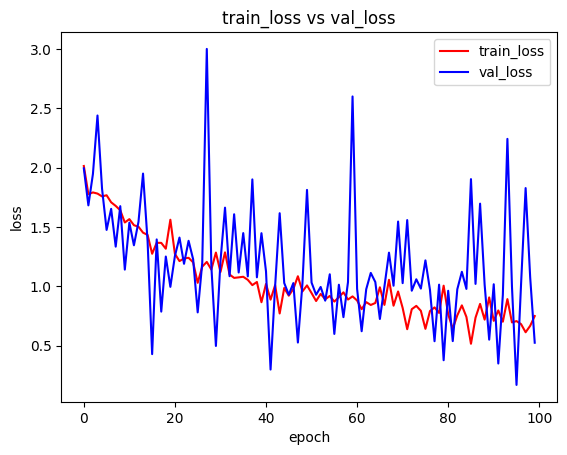

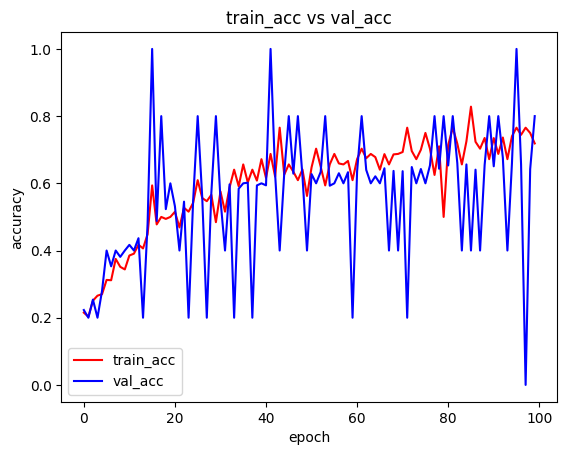

<Figure size 640x480 with 0 Axes>

In [13]:
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [14]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6452 - loss: 1.0922
Test Loss 1.0790470838546753
Test Acc: 0.6425188183784485


In [15]:
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts() 

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


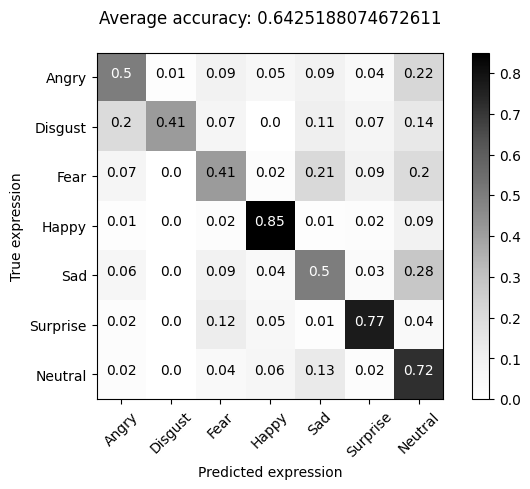

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')


# Save the Model

In [18]:
model.save('/kaggle/working/Fer2013.h5')
print("Saved model to disk")

Saved model to disk


#  Testing the Model using Webcam Feed

## Loading the saved model

In [20]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/Fer2013.h5')

## Loading Har-Cascade for Face Detection

In [21]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
    
import cv2

face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-08-30 19:52:06--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: 'haarcascade_frontalface_default.xml'

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.06s   

2024-08-30 19:52:06 (15.0 MB/s) - 'haarcascade_frontalface_default.xml' saved [930127/930127]



* We are using Haar-cascade for the detection position of faces and after getting position we will crop the faces.

# Read Frames and apply Preprocessing using OpenCV

## Use OpenCV to read frames and for image processing

In [23]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

cap = cv2.VideoCapture(0)
while cap.isOpened():
    res, frame = cap.read()
    height, width, channel = frame.shape
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_haar_cascade.detectMultiScale(gray_image)

    try:
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, pt1=(x, y), pt2=(x+w, y+h), color=(255, 0, 0), thickness=2)
            roi_gray = gray_image[y-5:y+h+5, x-5:x+w+5]
            roi_gray = cv2.resize(roi_gray, (48, 48))
            image_pixels = img_to_array(roi_gray)
            image_pixels = np.expand_dims(image_pixels, axis=0)
            image_pixels /= 255

            predictions = model.predict(image_pixels)
            max_index = np.argmax(predictions[0])
            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            emotion_prediction = emotion_detection[max_index]

            cv2.putText(frame, emotion_prediction, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    except Exception as e:
        print("Error:", e)

    cv2.imshow('Emotion Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


[ WARN:0@216.823] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@216.824] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


* here emotion_prediction returns the label of emotion.
* normalize test images by dividing them by 255.
* np.expand_dims convert a 3D matrix into a 4D tensor.
* (x,y,w,h) are the coordinates of faces in the input frame.
* haar_cascade takes only grayscale images.

## Adding Overlay

* Adding an overlay on the output frame and displaying the prediction with confidence gives a better look.

In [ ]:
cap=cv2.VideoCapture(1)
while cap.isOpened():
    res,frame=cap.read()
    height, width , channel = frame.shape#---------------------------------------------------------------------------
    # Creating an Overlay window to write prediction and cofidencesub_img = frame[0:int(height/6),0:int(width)]black_rect = np.ones(sub_img.shape, dtype=np.uint8)*0
    res = cv2.addWeighted(sub_img, 0.77, black_rect,0.23, 0)
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    FONT_SCALE = 0.8
    FONT_THICKNESS = 2
    lable_color = (10, 10, 255)
    lable = "Emotion Detection made by Abhishek"
    lable_dimension = cv2.getTextSize(lable,FONT ,FONT_SCALE,FONT_THICKNESS)[0]
    textX = int((res.shape[1] - lable_dimension[0]) / 2)
    textY = int((res.shape[0] + lable_dimension[1]) / 2)
    cv2.putText(res, lable, (textX,textY), FONT, FONT_SCALE, (0,0,0), FONT_THICKNESS)# prediction part --------------------------------------------------------------------------gray_image= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_haar_cascade.detectMultiScale(gray_image )
    try:
        for (x,y, w, h) in faces:
            cv2.rectangle(frame, pt1 = (x,y),pt2 = (x+w, y+h), color = (255,0,0),thickness =  2)
            roi_gray = gray_image[y-5:y+h+5,x-5:x+w+5]
            roi_gray=cv2.resize(roi_gray,(48,48))
            image_pixels = img_to_array(roi_gray)
            image_pixels = np.expand_dims(image_pixels, axis = 0)
            image_pixels /= 255
            predictions = model.predict(image_pixels)
            max_index = np.argmax(predictions[0])
            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            emotion_prediction = emotion_detection[max_index]
            cv2.putText(res, "Sentiment: {}".format(emotion_prediction), (0,textY+22+5), FONT,0.7, lable_color,2)
            lable_violation = 'Confidence: {}'.format(str(np.round(np.max(predictions[0])*100,1))+ "%")
            violation_text_dimension = cv2.getTextSize(lable_violation,FONT,FONT_SCALE,FONT_THICKNESS )[0]
            violation_x_axis = int(res.shape[1]- violation_text_dimension[0])
            cv2.putText(res, lable_violation, (violation_x_axis,textY+22+5), FONT,0.7, lable_color,2)
    except :
        pass
    frame[0:int(height/6),0:int(width)] = res
    cv2.imshow('frame', frame)if cv2.waitKey(1) & 0xFF == ord('q'):
        breakcap.release()
cv2.destroyAllWindows